# Using Ensemble to combine Logistic, SVM and Random Forest Regressions
**Why Try an Ensemble?**
- Robustness: Ensemble methods combine the strengths of individual models, often leading to improved performance and better generalization.
- Variance Reduction: By averaging predictions, ensembles can reduce variance and be less sensitive to noise in the data.
- Diverse Decision Boundaries: Different models (linear vs. non-linear) capture different aspects of the data, so their combination may yield better overall predictions.

Below is a complete, modular pipeline that builds an ensemble classifier (using Logistic Regression, SVM, and Random Forest) on deep features extracted from the images. This pipeline uses K‑fold methods for robust evaluation (here, we use a train–test split for demonstration, but you can easily wrap it in a K‑fold loop), applies feature extraction with MobileNetV2, scales features, and then trains an ensemble using a VotingClassifier with soft voting. I’ve also included comments explaining each step.

In [3]:
#############################################
# Chunk 1: Imports, Seeds, and Setup
#############################################
import os
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, f1_score
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

#############################################
# Chunk 2: Data Collection and Label Encoding
#############################################
def get_image_paths_and_labels(directory):
    file_paths = []
    labels = []
    # List subdirectories (classes) in sorted order
    classes = sorted([d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])
    for cls in classes:
        cls_dir = os.path.join(directory, cls)
        for file in os.listdir(cls_dir):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_paths.append(os.path.join(cls_dir, file))
                labels.append(cls)
    return pd.DataFrame({'file_path': file_paths, 'label': labels})

# Define the copied training directory (adjust path if needed)
new_train_dir = os.path.join('intel_dataset_copy', 'seg_train', 'seg_train')
df = get_image_paths_and_labels(new_train_dir)
print("Sample image paths and labels:")
print(df.head())

# Encode labels into numerical values
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

#############################################
# Chunk 3: Feature Extraction using MobileNetV2
#############################################
# Load MobileNetV2 (pre-trained on ImageNet, without top layers)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150,150,3))
# Use GlobalAveragePooling2D to obtain a fixed-length feature vector
gap = GlobalAveragePooling2D()(base_model.output)
feature_extractor = Model(inputs=base_model.input, outputs=gap)

def extract_features(file_path, target_size=(150,150)):
    img = load_img(file_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = feature_extractor.predict(img_array, verbose=0)
    return features.flatten()

# Extract features for all images (or a subset for faster prototyping)
df_sample = df  # Use full dataset if desired

features = []
for path in tqdm(df_sample['file_path'], desc="Extracting features"):
    feat = extract_features(path)
    features.append(feat)
features = np.array(features)
print("Extracted features shape:", features.shape)

#############################################
# Chunk 4: Feature Scaling
#############################################
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

#############################################
# Chunk 5: K-Fold Validation and Ensemble Model Training
#############################################
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
folds = list(skf.split(features_scaled, df_sample['label_encoded']))
print(f"Total folds: {len(folds)}")

fold_f1_scores = []
fold_reports = []

# Loop over each fold
fold = 1
for train_idx, test_idx in folds:
    print(f"\n--- Fold {fold} ---")
    X_train, X_test = features_scaled[train_idx], features_scaled[test_idx]
    y_train, y_test = df_sample['label_encoded'].values[train_idx], df_sample['label_encoded'].values[test_idx]
    
    # Define individual classifiers
    lr_model = LogisticRegression(max_iter=500, solver='liblinear', random_state=42)
    svm_model = SVC(kernel='linear', probability=True, random_state=42)  # Enable probability for soft voting
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    
    # Create ensemble using VotingClassifier (soft voting)
    ensemble = VotingClassifier(
        estimators=[('lr', lr_model), ('svm', svm_model), ('rf', rf_model)],
        voting='soft'
    )
    
    # Train ensemble on the current fold
    ensemble.fit(X_train, y_train)
    
    # Evaluate on the test split of this fold
    y_pred = ensemble.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("Fold", fold, "Weighted F1 Score:", f1)
    fold_f1_scores.append(f1)
    
    report = classification_report(y_test, y_pred, target_names=le.classes_)
    print("Fold", fold, "Classification Report:\n", report)
    fold_reports.append(report)
    
    fold += 1

avg_f1 = np.mean(fold_f1_scores)
print("\nAverage Weighted F1 Score across folds:", avg_f1)


Sample image paths and labels:
                                           file_path      label
0  intel_dataset_copy/seg_train/seg_train/buildin...  buildings
1  intel_dataset_copy/seg_train/seg_train/buildin...  buildings
2  intel_dataset_copy/seg_train/seg_train/buildin...  buildings
3  intel_dataset_copy/seg_train/seg_train/buildin...  buildings
4  intel_dataset_copy/seg_train/seg_train/buildin...  buildings


/var/folders/jk/60n1sr0j45ggchrdnrr6vts00000gn/T/ipykernel_45541/2985432998.py:55: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150,150,3))
Extracting features: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14016/14016 [12:29<00:00, 18.69it/s]


Extracted features shape: (14016, 1280)
Total folds: 5

--- Fold 1 ---
Fold 1 Weighted F1 Score: 0.8902097549721185
Fold 1 Classification Report:
               precision    recall  f1-score   support

   buildings       0.91      0.91      0.91       438
      forest       0.99      0.97      0.98       454
     glacier       0.81      0.79      0.80       481
    mountain       0.82      0.82      0.82       501
         sea       0.92      0.96      0.94       454
      street       0.90      0.92      0.91       476

    accuracy                           0.89      2804
   macro avg       0.89      0.89      0.89      2804
weighted avg       0.89      0.89      0.89      2804


--- Fold 2 ---
Fold 2 Weighted F1 Score: 0.8896000247694962
Fold 2 Classification Report:
               precision    recall  f1-score   support

   buildings       0.92      0.92      0.92       438
      forest       0.98      1.00      0.99       454
     glacier       0.80      0.79      0.79       481
 

Testing the final model using a confusion matrix:

Classification Report:
              precision    recall  f1-score   support

   buildings       0.90      0.90      0.90       438
      forest       0.99      0.99      0.99       453
     glacier       0.82      0.79      0.81       481
    mountain       0.81      0.83      0.82       501
         sea       0.93      0.93      0.93       455
      street       0.90      0.91      0.91       475

    accuracy                           0.89      2803
   macro avg       0.89      0.89      0.89      2803
weighted avg       0.89      0.89      0.89      2803

Weighted F1 Score: 0.8899936603811862


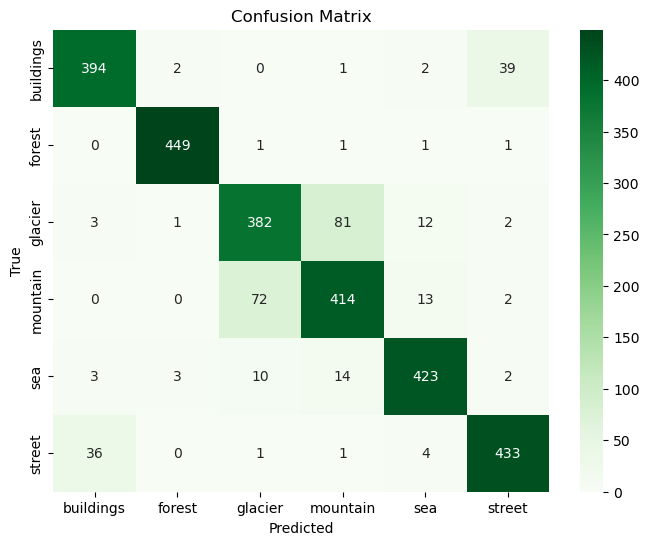

As we can see from the confusion matrix, the model is good at prediction with an 89% weighted F1 score on the test set. We see that the model is sometimes confused in predicting between (Mountain vs. Glacier) and (Building vs. Street). This can be understandable as the architecture and the layout of the sceneries are similar or in a similar area. Now, let's see the model work to predict some test images:


In [20]:
import numpy as np
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assume X_test and y_test are the final test set features and true labels (encoded)
# And 'ensemble' is your final ensemble model (or 'model' for a deep model)

# Make predictions on the test set
y_pred = ensemble.predict(X_test)  # or model.predict(...) if using a deep model

# Evaluate performance
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))
print("Weighted F1 Score:", f1_score(y_test, y_pred, average='weighted'))

# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("As we can see from the confusion matrix, the model is good at prediction with an 89% weighted F1 score on the test set. We see that the model is sometimes confused in predicting between (Mountain vs. Glacier) and (Building vs. Street). This can be understandable as the architecture and the layout of the sceneries are similar or in a similar area. Now, let's see the model work to predict some test images:")

Visualize the model's prediction on test set images:

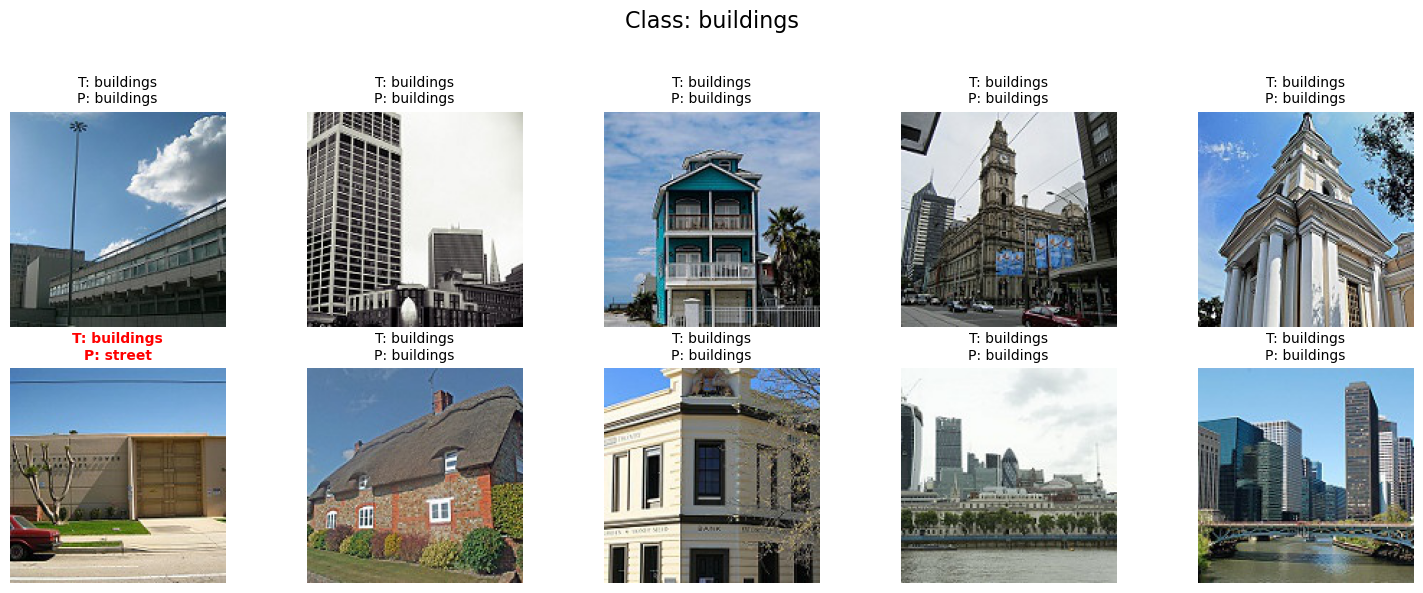

--------------------------------------------------------------------------------


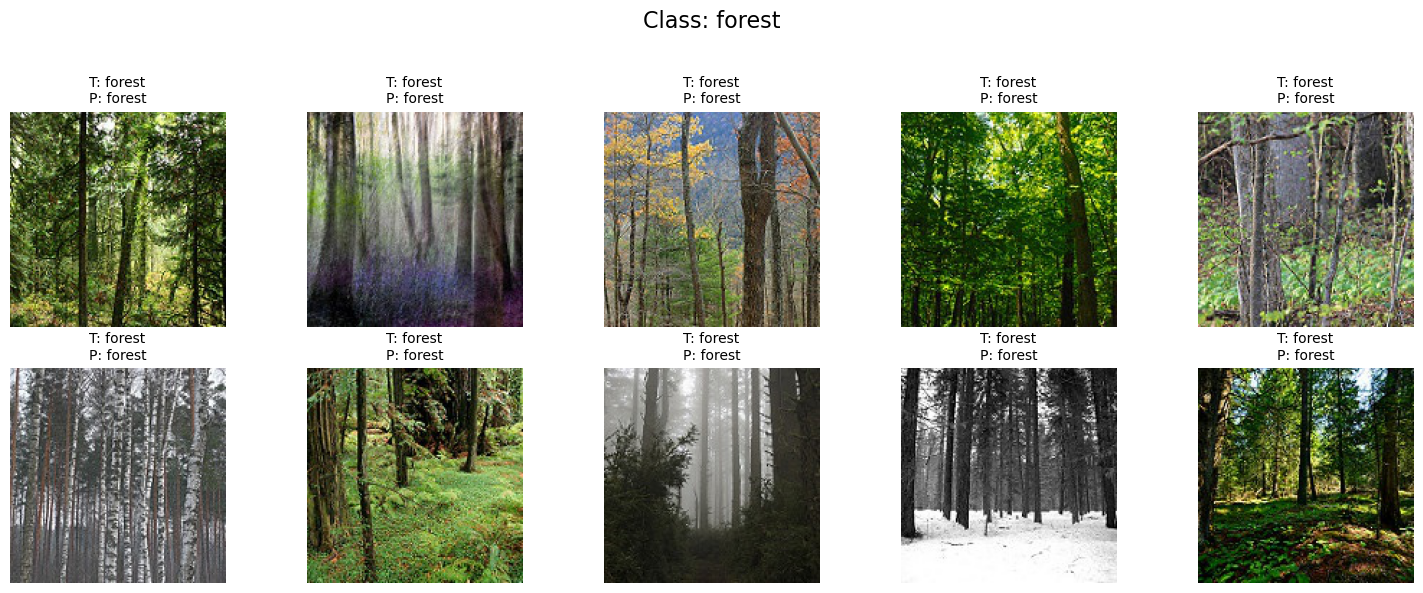

--------------------------------------------------------------------------------


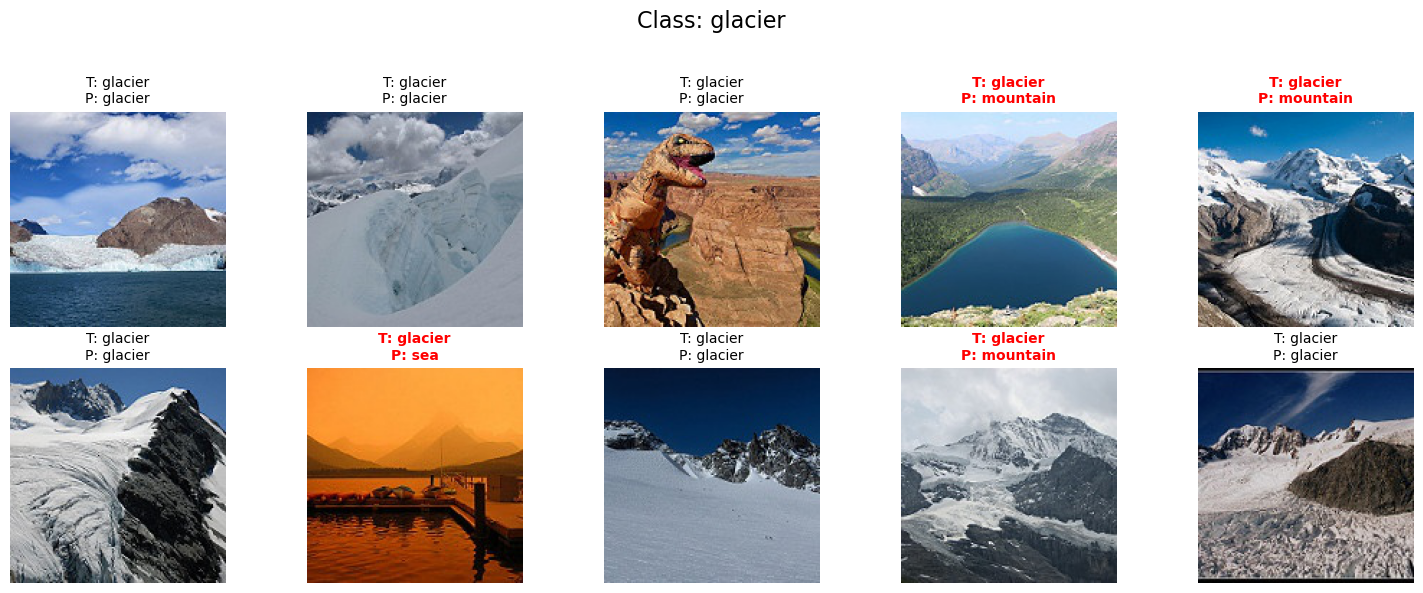

--------------------------------------------------------------------------------


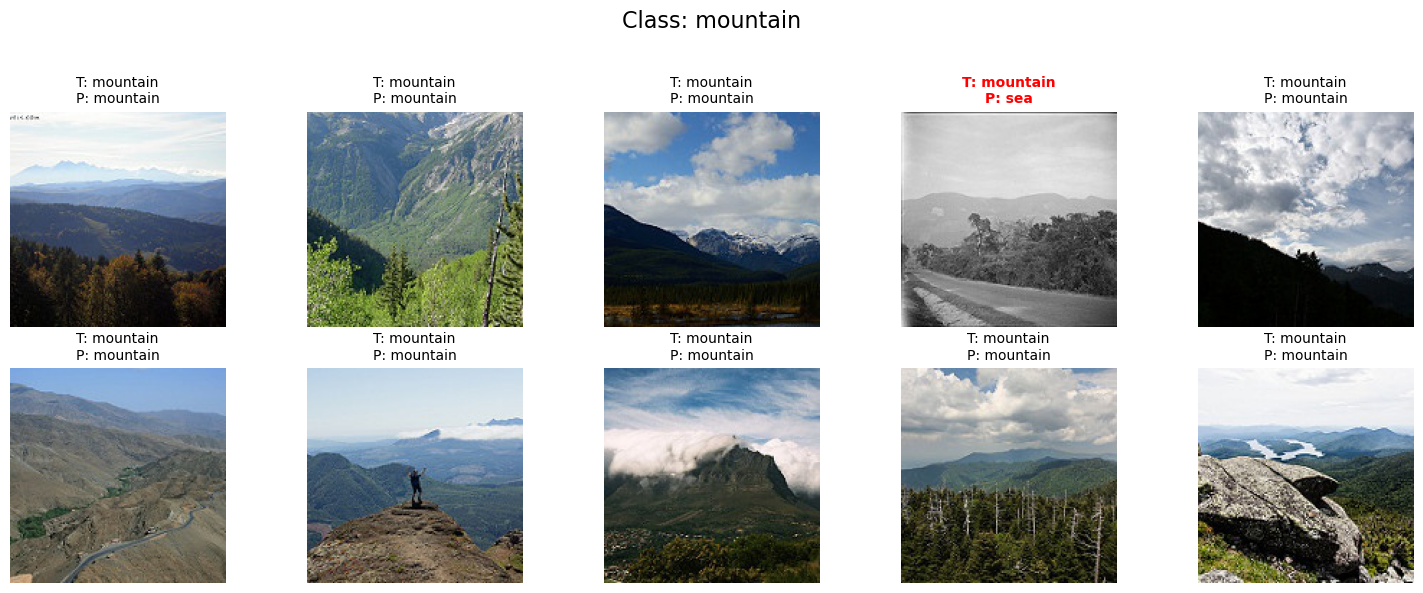

--------------------------------------------------------------------------------


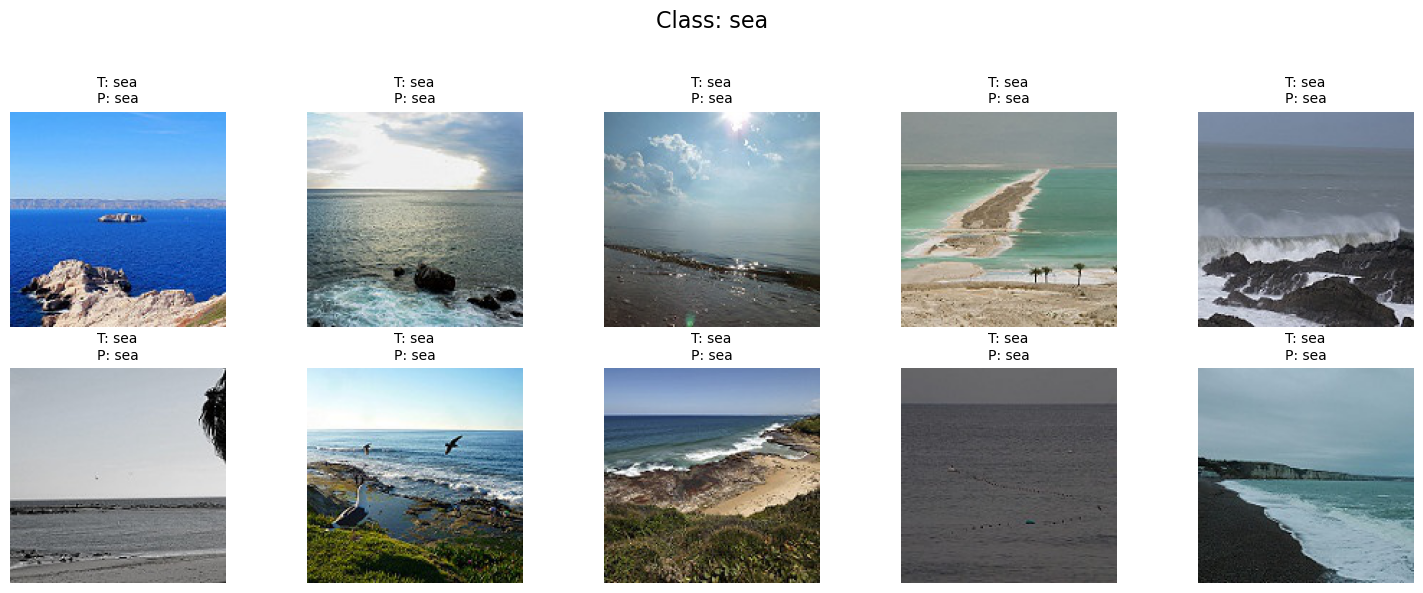

--------------------------------------------------------------------------------


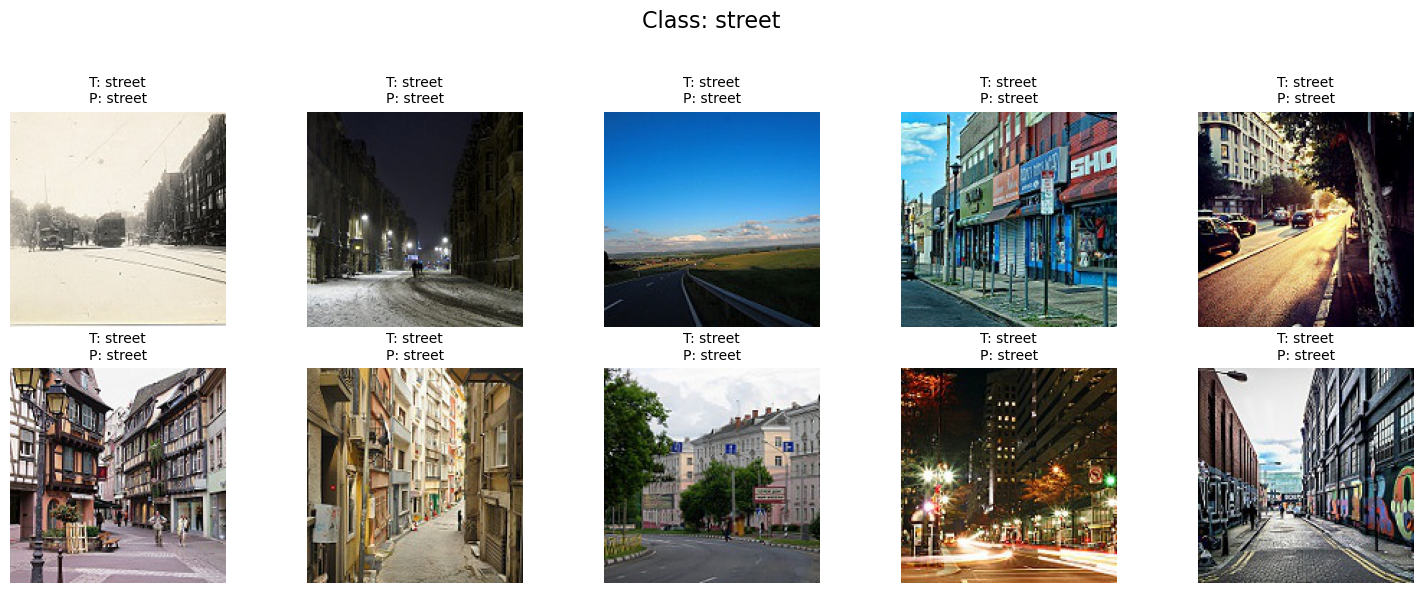

--------------------------------------------------------------------------------


In [16]:
import os
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

def display_test_predictions_grid(num_images=10, rows=2, cols=5, target_size=(150,150)):
    # Set random seed for reproducibility
    random.seed(42)
    
    # Define the copied test directory
    new_test_dir = os.path.join('intel_dataset_copy', 'seg_test', 'seg_test')
    # Get sorted list of classes (each folder corresponds to a class)
    classes = sorted([d for d in os.listdir(new_test_dir) if os.path.isdir(os.path.join(new_test_dir, d))])
    
    for cls in classes:
        class_dir = os.path.join(new_test_dir, cls)
        # Get a sorted list of image files in the class folder
        images = sorted([f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        # Determine number of images required per class (rows x cols)
        num_required = rows * cols
        # If available images are fewer than required, use all; otherwise, sample exactly num_required images
        if len(images) < num_required:
            selected = images
        else:
            selected = random.sample(images, num_required)
        
        # Create figure for the current class
        fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
        fig.suptitle(f"Class: {cls}", fontsize=16)
        
        # Flatten the axes array for easier iteration
        if rows * cols == 1:
            axes = [axes]
        else:
            axes = axes.flatten()
        
        for ax, img_file in zip(axes, selected):
            img_path = os.path.join(class_dir, img_file)
            # Load the image (resized for display)
            img = load_img(img_path, target_size=target_size)
            # Extract features and scale them using your previously defined functions
            feat = extract_features(img_path, target_size=target_size)
            feat_scaled = scaler.transform(feat.reshape(1, -1))
            # Get the prediction from the ensemble
            pred_encoded = ensemble.predict(feat_scaled)[0]
            pred_class = le.inverse_transform([pred_encoded])[0]
            true_class = cls
            
            # Create title text with true and predicted labels
            title_text = f"T: {true_class}\nP: {pred_class}"
            # If prediction is incorrect, display title in bold and red
            if pred_class != true_class:
                ax.set_title(title_text, fontweight='bold', color='red', fontsize=10)
            else:
                ax.set_title(title_text, fontsize=10)
            ax.imshow(img)
            ax.axis('off')
        
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
        print("-" * 80)

# Call the function to display 10 images per class in a 2-row by 5-column grid
display_test_predictions_grid(num_images=10, rows=2, cols=5, target_size=(150,150))